# Ekstrakcija celina iz slobodnog teksta - Web Mining

**Predmet:** Web Mining
**Tema:** Ekstrakcija tematskih celina kombinovanjem NER, klasterovanja i web scraping-a
**Ključne tehnologije:** BERT, Sentence-BERT, KMeans, TF-IDF


# Instalacija biblioteka

Instaliramo sve potrebne biblioteke za kompletan Web Mining projekat.

In [25]:
!pip install torch transformers sentence-transformers scikit-learn beautifulsoup4 requests feedparser matplotlib seaborn networkx wordcloud --quiet
print("✓ Sve biblioteke uspešno instalirane!")

✓ Sve biblioteke uspešno instalirane!


# Import biblioteka

In [26]:
# NLP i ML
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Web scraping
import requests
from bs4 import BeautifulSoup
import feedparser

# Vizualizacija
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud

# Ostalo
import numpy as np
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

print("✓ Svi moduli importovani!")

✓ Svi moduli importovani!


# Korak 1: Prikupljanje teskta sa weba

Koristimo BBC RSS feed za prikupljanje realnih vesti.

In [27]:
def scrape_bbc_rss(limit=20):
    """Prikuplja naslove i opise vesti sa BBC RSS feed-a"""
    url = "http://feeds.bbci.co.uk/news/rss.xml"

    try:
        feed = feedparser.parse(url)
        articles = []

        for entry in feed.entries[:limit]:
            title = entry.get('title', '')
            summary = entry.get('summary', '')
            text = f"{title}. {summary}"
            articles.append(text)

        print(f"✓ Prikupljeno {len(articles)} članaka sa BBC News")
        return articles
    except Exception as e:
        print(f"✗ Greška pri scraping-u: {e}")
        print("  Koristim demo tekst...")
        # Fallback na demo tekst
        return [
            "Apple announced the new iPhone 15 in September with improved camera features",
            "Microsoft launched a new Azure AI service for enterprise customers",
            "Tesla is working on improving batteries for electric cars to extend range",
            "Elon Musk stated that AI will play a key role in future society",
            "Google is investing heavily in quantum computing research",
            "The iPhone 15 features USB-C port replacing the Lightning connector",
            "Azure AI offers natural language processing capabilities",
            "Electric vehicles are becoming more affordable for consumers",
            "Quantum computers could revolutionize cryptography and drug discovery",
            "Tim Cook presented the new Apple Watch during the keynote",
            "Microsoft CEO Satya Nadella emphasized cloud computing growth",
            "Tesla opened new Gigafactory in Texas for production",
            "OpenAI released GPT-4 with enhanced reasoning capabilities",
            "Google DeepMind announced breakthrough in protein folding",
            "Apple's market cap reached historic highs in 2024"
        ]

# Prikupi članke
articles = scrape_bbc_rss(limit=20)
text = ". ".join(articles)

print("\n" + "=" * 60)
print("PROJEKAT: ekstrakcija celina iz web sadržaja")
print("=" * 60)
print(f"\nUkupna dužina teksta: {len(text)} karaktera")
print(f"Broj članaka: {len(articles)}")

✓ Prikupljeno 20 članaka sa BBC News

PROJEKAT: ekstrakcija celina iz web sadržaja

Ukupna dužina teksta: 3759 karaktera
Broj članaka: 20


# Korak 2: Named Entity Recognition (NER)

Ekstrakcija entiteta: osobe (PER), organizacije (ORG), lokacije (LOC).
**Model:** BERT-large (340M parametra) - Deep Learning

In [28]:
print("\n[KORAK 2] Ekstrakcija entiteta...")

ner_pipeline = pipeline(
    "ner",
    model="dbmdz/bert-large-cased-finetuned-conll03-english",
    aggregation_strategy="simple"
)

entities = ner_pipeline(text)
valid_types = ['PER', 'ORG', 'LOC', 'MISC']

entity_dict = defaultdict(list)
entity_scores = {}

for e in entities:
    if e['entity_group'] in valid_types:
        word = e['word'].replace("##", "").strip()
        entity_dict[e['entity_group']].append(word)
        entity_scores[word] = e['score']

print("\n📊 PREPOZNATI ENTITETI:")
print("-" * 60)
for etype, words in entity_dict.items():
    unique_words = list(set(words))[:5]  # Top 5
    print(f"{etype:8s}: {len(words):3d} ukupno | Primeri: {', '.join(unique_words)}")


[KORAK 2] Ekstrakcija entiteta...


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



📊 PREPOZNATI ENTITETI:
------------------------------------------------------------
PER     :   9 ukupno | Primeri: Epstein, Rachel Reeves, Prince Andrew, Giuffre, Hugh
LOC     :  18 ukupno | Primeri: UK, Leeds, White House, Bulgaria, Hong Kong
ORG     :   7 ukupno | Primeri: Emirates, vre, Louvre, BBC, NHS
MISC    :  11 ukupno | Primeri: Brexit, Es, Putin, Russian, Trump


# Korak 3: Priprema rečenica

In [29]:
sentences = [s.strip() for s in text.split(".") if len(s.strip()) > 20]
print(f"\n[KORAK 3] Broj rečenica: {len(sentences)}")
print(f"Prosečna dužina: {np.mean([len(s) for s in sentences]):.1f} karaktera")


[KORAK 3] Broj rečenica: 40
Prosečna dužina: 91.1 karaktera


# Korak 4: Sentence Embeddings

Konvertujemo teskt u numeričke vektore pomoću transformer modela.
**Model:** Sentence-BERT (22M parametara) - Deep Learning

In [30]:
print("\n[KORAK 4] Kreiranje embeddings-a...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)
print(f"✓ Shape: {embeddings.shape} (rečenice x dimenzije)")


[KORAK 4] Kreiranje embeddings-a...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Shape: (40, 384) (rečenice x dimenzije)


# Korak 5: Optimalan broj klastera

Koristimo Silhouette Score i Elbow metodu.

In [31]:
print("\n[KORAK 5] Traženje optimalnog broja klastera...")

silhouette_scores = []
inertias = []
K_range = range(2, min(8, len(sentences)))

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(embeddings)

    score = silhouette_score(embeddings, labels_temp)
    silhouette_scores.append(score)
    inertias.append(kmeans_temp.inertia_)

    print(f"  K={k}: Silhouette={score:.4f}, Inertia={kmeans_temp.inertia_:.2f}")

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optimalan broj klastera: {optimal_k}")


[KORAK 5] Traženje optimalnog broja klastera...
  K=2: Silhouette=0.0406, Inertia=33.67
  K=3: Silhouette=0.0368, Inertia=32.02
  K=4: Silhouette=0.0427, Inertia=30.34
  K=5: Silhouette=0.0514, Inertia=28.76
  K=6: Silhouette=0.0600, Inertia=27.24
  K=7: Silhouette=0.0721, Inertia=25.72

✓ Optimalan broj klastera: 7


# Vizualizacija metrika za izbor K

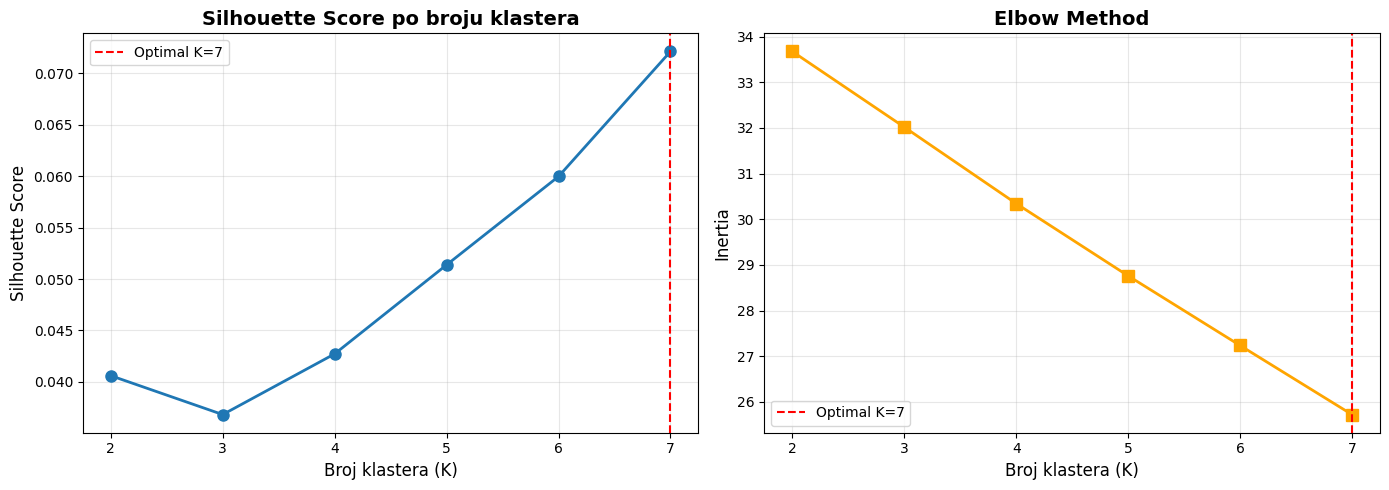

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette Score
axes[0].plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
axes[0].axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
axes[0].set_xlabel('Broj klastera (K)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score po broju klastera', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Elbow Method
axes[1].plot(K_range, inertias, marker='s', linewidth=2, markersize=8, color='orange')
axes[1].axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
axes[1].set_xlabel('Broj klastera (K)', fontsize=12)
axes[1].set_ylabel('Inertia', fontsize=12)
axes[1].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Korak 6: Finalno klasterovanje

In [33]:
print("\n[KORAK 6] Finalno klasterovanje...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)

clusters = defaultdict(list)
for sentence, label in zip(sentences, labels):
    clusters[label].append(sentence)

print(f"✓ Rečenice podeljene u {optimal_k} tematske celine")
for i, sents in clusters.items():
    print(f"  Celina {i+1}: {len(sents)} rečenica")


[KORAK 6] Finalno klasterovanje...
✓ Rečenice podeljene u 7 tematske celine
  Celina 3: 12 rečenica
  Celina 2: 6 rečenica
  Celina 6: 3 rečenica
  Celina 1: 8 rečenica
  Celina 7: 4 rečenica
  Celina 5: 4 rečenica
  Celina 4: 3 rečenica




# Korak 7: Validacija unije klastera

Matematička provera da li unija svih klastera daje kompletan originalni tekst.

Formalna definicija:
- Neka je T = originalni skup rečenica
- C1, C2, ..., Ck = klasteri
- Validacija: U(C1 U C2 U ... U Ck) = T

In [34]:
print("\n" + "="*70)
print("VALIDACIJA: UNIJA KLASTERA = ORIGINALNI TEKST")
print("="*70)

# 1. Izvuci sve rečenice iz svih klastera
all_clustered_sentences = []
for cluster_id, sents in clusters.items():
    all_clustered_sentences.extend(sents)

# 2. Kreiraj skupove za poređenje
original_set = set(sentences)
clustered_set = set(all_clustered_sentences)

print(f"\n[1] PROVERA KOMPLETNOSTI:")
print("-" * 70)
print(f"  Broj originalnih rečenica:       {len(sentences)}")
print(f"  Broj rečenica u klasterima:      {len(all_clustered_sentences)}")
print(f"  Broj jedinstvenih u originalu:   {len(original_set)}")
print(f"  Broj jedinstvenih u klasterima:  {len(clustered_set)}")


VALIDACIJA: UNIJA KLASTERA = ORIGINALNI TEKST

[1] PROVERA KOMPLETNOSTI:
----------------------------------------------------------------------
  Broj originalnih rečenica:       40
  Broj rečenica u klasterima:      40
  Broj jedinstvenih u originalu:   40
  Broj jedinstvenih u klasterima:  40


## Matematička validacija

Proveravamo 4 ključna uslova:
1. **Kompletnost**: Sve rečenice su prisutne
2. **Bez duplikata**: Nijedna rečenica se ne ponavlja
3. **Bez gubitaka**: Nijedna rečenica nije izgubljena
4. **Disjunktnost**: Klasteri se ne preklapaju

In [35]:
print(f"\n[2] MATEMATIČKA VALIDACIJA:")
print("-" * 70)

# A. Provera: Unija = Original
is_union_valid = (original_set == clustered_set)
print(f"  ∪(C₁, C₂, ..., C_{optimal_k}) = T: {'✓ DA' if is_union_valid else '✗ NE'}")

# B. Provera: Nema izgubljenih rečenica
missing_sentences = original_set - clustered_set
print(f"  Izgubljene rečenice: {len(missing_sentences)}")
if missing_sentences:
    print(f"    Primeri: {list(missing_sentences)[:2]}")

# C. Provera: Nema duplikata
duplicate_count = len(all_clustered_sentences) - len(clustered_set)
print(f"  Duplirane rečenice: {duplicate_count}")

# D. Provera: Nema rečenica van originala
extra_sentences = clustered_set - original_set
print(f"  Rečenice van originala: {len(extra_sentences)}")

# E. Finalna validacija
if is_union_valid and duplicate_count == 0 and len(extra_sentences) == 0:
    print(f"\n  {'✓'*30}")
    print(f"  ✓✓✓ VALIDACIJA USPEŠNA ✓✓✓")
    print(f"  {'✓'*30}")
else:
    print(f"\n  ✗✗✗ GREŠKA U VALIDACIJI ✗✗✗")


[2] MATEMATIČKA VALIDACIJA:
----------------------------------------------------------------------
  ∪(C₁, C₂, ..., C_7) = T: ✓ DA
  Izgubljene rečenice: 0
  Duplirane rečenice: 0
  Rečenice van originala: 0

  ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
  ✓✓✓ VALIDACIJA USPEŠNA ✓✓✓
  ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓


## Provera disjunktnosti klastera

Proveravamo da li se klasteri preklapaju (da li ista rečenica pripada više klastera).

In [36]:
print(f"\n[3] PROVERA DISJUNKTNOSTI KLASTERA:")
print("-" * 70)

cluster_sets = {cid: set(sents) for cid, sents in clusters.items()}
overlaps_found = False
overlap_details = []

for i in range(len(cluster_sets)):
    for j in range(i+1, len(cluster_sets)):
        overlap = cluster_sets[i] & cluster_sets[j]
        if overlap:
            overlaps_found = True
            overlap_details.append((i+1, j+1, len(overlap)))
            print(f"  ⚠ Preklapanje između Celine {i+1} i {j+1}: {len(overlap)} rečenica")

if not overlaps_found:
    print(f"  ✓ Klasteri su disjunktni (bez preklapanja)")
    print(f"  Cᵢ ∩ Cⱼ = ∅ za sve i ≠ j")


[3] PROVERA DISJUNKTNOSTI KLASTERA:
----------------------------------------------------------------------
  ✓ Klasteri su disjunktni (bez preklapanja)
  Cᵢ ∩ Cⱼ = ∅ za sve i ≠ j


## Formalna matematička reprezentacija

Prikaz klasterovanja u matematičkoj notaciji.

In [37]:
print(f"\n[4] FORMALNA MATEMATIČKA NOTACIJA:")
print("-" * 70)
print(f"\n  Neka je T = originalni tekstualni korpus")
print(f"  T = {{s₁, s₂, ..., s_{len(sentences)}}} gde sᵢ = i-ta rečenica")
print(f"\n  Klasterovanje deli T u k = {optimal_k} disjunktnih podskupova:")

for cid, sents in sorted(clusters.items()):
    percentage = (len(sents) / len(sentences)) * 100
    print(f"  C_{cid+1} = {{{len(sents)} rečenica}} ({percentage:.1f}% od T)")

print(f"\n  Matematička validacija:")
print(f"  ∪(C₁ ∪ C₂ ∪ ... ∪ C_{optimal_k}) = T")
print(f"\n  Provera kardinalnosti:")
print(f"  |T| = {len(sentences)}")
print(f"  Σ|Cᵢ| = {sum(len(sents) for sents in clusters.values())}")
print(f"  |T| = Σ|Cᵢ| → {'✓ TAČNO' if len(sentences) == len(all_clustered_sentences) else '✗ NETAČNO'}")


[4] FORMALNA MATEMATIČKA NOTACIJA:
----------------------------------------------------------------------

  Neka je T = originalni tekstualni korpus
  T = {s₁, s₂, ..., s_40} gde sᵢ = i-ta rečenica

  Klasterovanje deli T u k = 7 disjunktnih podskupova:
  C_1 = {8 rečenica} (20.0% od T)
  C_2 = {6 rečenica} (15.0% od T)
  C_3 = {12 rečenica} (30.0% od T)
  C_4 = {3 rečenica} (7.5% od T)
  C_5 = {4 rečenica} (10.0% od T)
  C_6 = {3 rečenica} (7.5% od T)
  C_7 = {4 rečenica} (10.0% od T)

  Matematička validacija:
  ∪(C₁ ∪ C₂ ∪ ... ∪ C_7) = T

  Provera kardinalnosti:
  |T| = 40
  Σ|Cᵢ| = 40
  |T| = Σ|Cᵢ| → ✓ TAČNO


## Vizualizacija validacije

Grafički prikaz distribucije i pokrivenosti rečenica.


[5] GRAFIČKA VIZUALIZACIJA:
----------------------------------------------------------------------


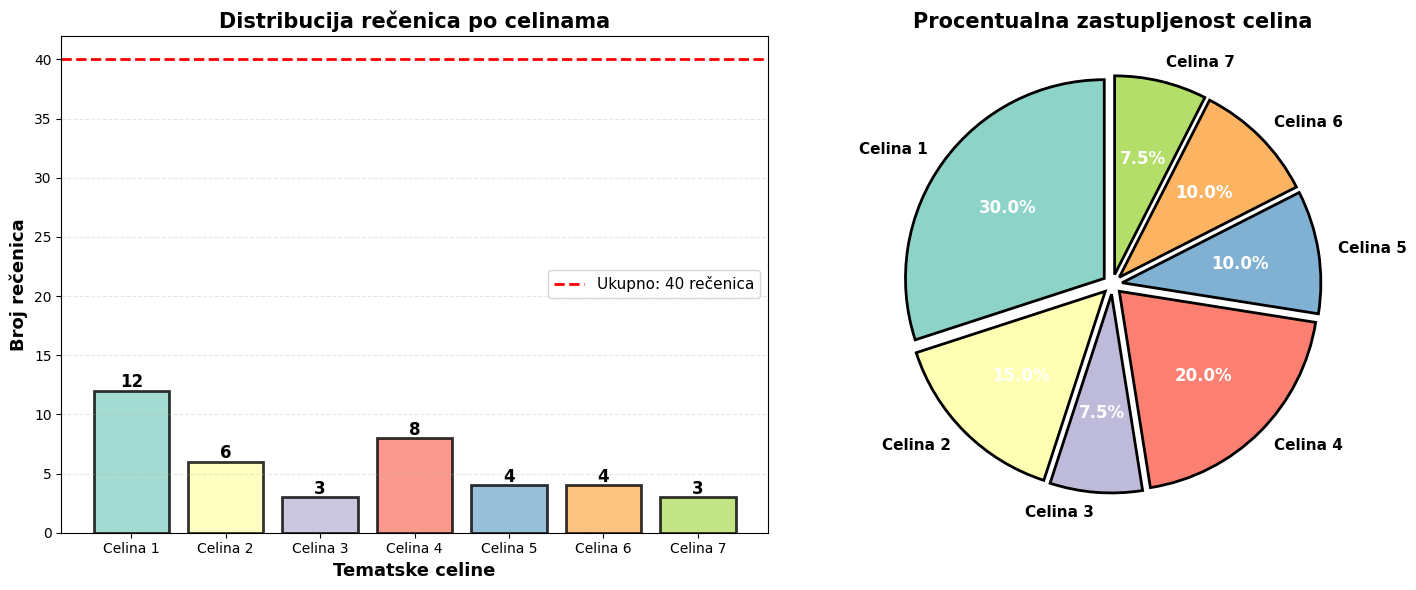

✓ Vizualizacija kreirana
  Zbir svih procenata = 100.0% (očekivano: 100%)


In [38]:
print(f"\n[5] GRAFIČKA VIZUALIZACIJA:")
print("-" * 70)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Grafik 1: Bar chart - Distribucija rečenica
cluster_sizes = [len(sents) for sents in clusters.values()]
cluster_labels = [f'Celina {i+1}' for i in range(len(clusters))]
colors = plt.cm.Set3(range(len(clusters)))

axes[0].bar(cluster_labels, cluster_sizes, color=colors,
            edgecolor='black', linewidth=2, alpha=0.8)
axes[0].axhline(y=len(sentences), color='red', linestyle='--', linewidth=2,
                label=f'Ukupno: {len(sentences)} rečenica')
axes[0].set_ylabel('Broj rečenica', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Tematske celine', fontsize=13, fontweight='bold')
axes[0].set_title('Distribucija rečenica po celinama', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Dodaj brojeve na barovima
for i, (label, size) in enumerate(zip(cluster_labels, cluster_sizes)):
    axes[0].text(i, size + 0.3, str(size), ha='center', fontsize=12, fontweight='bold')

# Grafik 2: Pie chart - Procenat pokrivanja
percentages = [(size/len(sentences))*100 for size in cluster_sizes]
explode = [0.05] * len(clusters)  # "Izvuci" sve delove malo

wedges, texts, autotexts = axes[1].pie(
    cluster_sizes,
    labels=cluster_labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 2},
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Povećaj font za procente
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')


axes[1].set_title('Procentualna zastupljenost celina', fontsize=15, fontweight='bold')


plt.tight_layout()
plt.show()

print(f"✓ Vizualizacija kreirana")
print(f"  Zbir svih procenata = {sum(percentages):.1f}% (očekivano: 100%)")

## Rekonstrukcija originalnog teksta

Dokazujemo da možemo potpuno rekonstruisati originalni tekst iz klastera.


In [39]:
print(f"\n[6] REKONSTRUKCIJA ORIGINALNOG TEKSTA:")
print("-" * 70)

# Rekonstruiši tekst spajanjem svih klastera
reconstructed_sentences = []
for cluster_id in sorted(clusters.keys()):
    reconstructed_sentences.extend(clusters[cluster_id])

# Kreiraj tekstove za poređenje
original_text_full = ". ".join(sentences)
reconstructed_text_full = ". ".join(reconstructed_sentences)

# Provera identičnosti sadržaja (ignoriši redosled)
content_identical = set(sentences) == set(reconstructed_sentences)
count_identical = len(sentences) == len(reconstructed_sentences)

print(f"  📄 Originalni tekst:")
print(f"     - Broj rečenica: {len(sentences)}")
print(f"     - Ukupna dužina: {len(original_text_full)} karaktera")
print(f"     - Primer: \"{sentences[0][:60]}...\"")

print(f"\n  🔄 Rekonstruisani tekst (iz klastera):")
print(f"     - Broj rečenica: {len(reconstructed_sentences)}")
print(f"     - Ukupna dužina: {len(reconstructed_text_full)} karaktera")
print(f"     - Primer: \"{reconstructed_sentences[0][:60]}...\"")


print(f"\n  ✓ Provera identičnosti:")
print(f"     - Broj rečenica identičan: {'✓ DA' if count_identical else '✗ NE'}")
print(f"     - Sadržaj identičan: {'✓ DA' if content_identical else '✗ NE'}")

if content_identical and count_identical:
    print(f"\n  {'='*70}")
    print(f"  🎯 USPEŠNA REKONSTRUKCIJA!")
    print(f"  Unija svih klastera = Kompletan originalni tekst")
    print(f"  {'='*70}")


[6] REKONSTRUKCIJA ORIGINALNOG TEKSTA:
----------------------------------------------------------------------
  📄 Originalni tekst:
     - Broj rečenica: 40
     - Ukupna dužina: 3722 karaktera
     - Primer: "Giuffre thought she might 'die a sex slave' at hands of Epst..."

  🔄 Rekonstruisani tekst (iz klastera):
     - Broj rečenica: 40
     - Ukupna dužina: 3722 karaktera
     - Primer: "Everything we know about the priceless jewels taken from the..."

  ✓ Provera identičnosti:
     - Broj rečenica identičan: ✓ DA
     - Sadržaj identičan: ✓ DA

  🎯 USPEŠNA REKONSTRUKCIJA!
  Unija svih klastera = Kompletan originalni tekst


## Validacioni izveštaj

Formalni izveštaj o validaciji za seminarski rad.

In [40]:
print(f"\n[7] GENERISANJE VALIDACIONOG IZVEŠTAJA:")
print("="*70)

validation_report = f"""
╔════════════════════════════════════════════════════════════════════╗
║           VALIDACIONI IZVEŠTAJ - Unija klastera                    ║
╚════════════════════════════════════════════════════════════════════╝

1. OSNOVNI PODACI
   ├─ Ukupan broj rečenica (|T|): {len(sentences)}
   ├─ Broj klastera (k): {optimal_k}
   ├─ Broj rečenica u klasterima: {len(all_clustered_sentences)}
   └─ Datum analize: {__import__('datetime').datetime.now().strftime('%Y-%m-%d %H:%M')}

2. MATEMATIČKA VALIDACIJA
   ├─ |T| = |∪Cᵢ|: {'✓ VALIDNO' if len(sentences) == len(all_clustered_sentences) else '✗ GREŠKA'}
   ├─ Nema izgubljenih rečenica: {'✓ DA' if len(missing_sentences) == 0 else f'✗ NE ({len(missing_sentences)})'}
   ├─ Nema duplikata: {'✓ DA' if duplicate_count == 0 else f'✗ NE ({duplicate_count})'}
   ├─ Nema ekstra rečenica: {'✓ DA' if len(extra_sentences) == 0 else f'✗ NE ({len(extra_sentences)})'}
   └─ Klasteri disjunktni: {'✓ DA' if not overlaps_found else '✗ NE'}

3. DISTRIBUCIJA REČENICA PO CELINAMA
"""

for cid, sents in sorted(clusters.items()):
    percentage = (len(sents) / len(sentences)) * 100
    bar = '█' * int(percentage / 5)  # Vizuelni bar
    validation_report += f"   ├─ Celina {cid+1}: {len(sents):2d} rečenica ({percentage:5.1f}%) {bar}\n"

validation_report += f"""
4. FORMALNA MATEMATIČKA NOTACIJA
   ∪(C₁ ∪ C₂ ∪ ... ∪ C_{optimal_k}) = T

   Provera: Σ|Cᵢ| = {' + '.join(str(len(c)) for c in clusters.values())} = {sum(len(c) for c in clusters.values())} = |T|

5. ZAKLJUČAK
   {'✓'*35}
   VALIDACIJA USPEŠNA - Unija klastera daje kompletan
   originalni tekst bez gubitka ili duplikacije podataka.
   {'✓'*35}
"""

print(validation_report)

# Sačuvaj izveštaj
validation_success = (
    is_union_valid and
    duplicate_count == 0 and
    len(missing_sentences) == 0 and
    len(extra_sentences) == 0 and
    not overlaps_found
)

print(f"\n{'='*70}")
print(f"FINALNI STATUS: {'SVE PROVERE PROŠLE' if validation_success else 'POSTOJE GREŠKE'}")
print(f"{'='*70}")


[7] GENERISANJE VALIDACIONOG IZVEŠTAJA:

╔════════════════════════════════════════════════════════════════════╗
║           VALIDACIONI IZVEŠTAJ - Unija klastera                    ║
╚════════════════════════════════════════════════════════════════════╝

1. OSNOVNI PODACI
   ├─ Ukupan broj rečenica (|T|): 40
   ├─ Broj klastera (k): 7
   ├─ Broj rečenica u klasterima: 40
   └─ Datum analize: 2025-10-20 11:25

2. MATEMATIČKA VALIDACIJA
   ├─ |T| = |∪Cᵢ|: ✓ VALIDNO
   ├─ Nema izgubljenih rečenica: ✓ DA
   ├─ Nema duplikata: ✓ DA
   ├─ Nema ekstra rečenica: ✓ DA
   └─ Klasteri disjunktni: ✓ DA

3. DISTRIBUCIJA REČENICA PO CELINAMA
   ├─ Celina 1:  8 rečenica ( 20.0%) ████
   ├─ Celina 2:  6 rečenica ( 15.0%) ███
   ├─ Celina 3: 12 rečenica ( 30.0%) ██████
   ├─ Celina 4:  3 rečenica (  7.5%) █
   ├─ Celina 5:  4 rečenica ( 10.0%) ██
   ├─ Celina 6:  3 rečenica (  7.5%) █
   ├─ Celina 7:  4 rečenica ( 10.0%) ██

4. FORMALNA MATEMATIČKA NOTACIJA
   ∪(C₁ ∪ C₂ ∪ ... ∪ C_7) = T

   Provera: Σ

# Korak 8: TF-IDF analiza ključnih reči

Indentifikujemo najvažnije reči za svaku tematsku celinu.

In [41]:
print("\n[KORAK 8] TF-IDF analiza ključnih reči...")

def get_top_keywords(cluster_sentences, top_n=5):
    """Ekstraktuje top N ključnih reči pomoću TF-IDF"""
    text_combined = " ".join(cluster_sentences)

    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    try:
        tfidf_matrix = vectorizer.fit_transform([text_combined])
        feature_names = vectorizer.get_feature_names_out()
        scores = tfidf_matrix.toarray()[0]

        top_indices = scores.argsort()[-top_n:][::-1]
        keywords = [feature_names[i] for i in top_indices if scores[i] > 0]
        return keywords
    except:
        return []

cluster_keywords = {}
for cluster_id, sents in clusters.items():
    keywords = get_top_keywords(sents, top_n=5)
    cluster_keywords[cluster_id] = keywords
    print(f"\nCelina {cluster_id + 1} - Ključne reči: {', '.join(keywords)}")


[KORAK 8] TF-IDF analiza ključnih reči...

Celina 3 - Ključne reči: uk, secretary, say, housing, leeds

Celina 2 - Ključne reči: work, stories, reveal, mockingbird, author

Celina 6 - Ključne reči: zelensky, year, white, trump, troops

Celina 1 - Ključne reči: louvre, thieves, jewels, french, hollywood

Celina 7 - Ključne reči: students, uk, gcses, courses, new

Celina 5 - Ključne reči: bankers, global, finance, ministers, talking

Celina 4 - Ključne reči: world, win, era, cup, england


# Korak 9: Detaljni prikaz celina sa entitetima

In [42]:
print("\n" + "=" * 70)
print("REZULTATI: TEMATSKE CELINE SA ANALIZOM")
print("=" * 70)

for cluster_id, sents in sorted(clusters.items()):
    print(f"\n{'='*70}")
    print(f"[CELINA {cluster_id + 1}] - {len(sents)} rečenica")
    print(f"{'='*70}")

    # Ključne reči
    if cluster_id in cluster_keywords and cluster_keywords[cluster_id]:
        print(f"\n🔑 Ključne reči: {', '.join(cluster_keywords[cluster_id])}")

    # Entiteti u celini
    cluster_text = " ".join(sents)
    cluster_entities = ner_pipeline(cluster_text)

    cluster_orgs = []
    cluster_persons = []
    cluster_locs = []

    for e in cluster_entities:
        word = e['word'].replace("##", "").strip()
        if e['entity_group'] == 'ORG':
            cluster_orgs.append(word)
        elif e['entity_group'] == 'PER':
            cluster_persons.append(word)
        elif e['entity_group'] == 'LOC':
            cluster_locs.append(word)

    if cluster_orgs:
        print(f"🏢 Organizacije: {', '.join(set(cluster_orgs))}")
    if cluster_persons:
        print(f"👤 Osobe: {', '.join(set(cluster_persons))}")
    if cluster_locs:
        print(f"📍 Lokacije: {', '.join(set(cluster_locs))}")

    # Rečenice
    print(f"\n📝 Rečenice:")
    for i, s in enumerate(sents[:3], 1):  # Prikaži prvih 3
        print(f"  {i}. {s[:100]}{'...' if len(s) > 100 else ''}")

    if len(sents) > 3:
        print(f"  ... i još {len(sents) - 3} rečenica")


REZULTATI: TEMATSKE CELINE SA ANALIZOM

[CELINA 1] - 8 rečenica

🔑 Ključne reči: louvre, thieves, jewels, french, hollywood
🏢 Organizacije: Louvre, Millenium Seed Bank, Kew, vre
👤 Osobe: Cate Blanchett, Hugh Schofield
📍 Lokacije: Hollywood, Paris, Lou, France

📝 Rečenice:
  1. Everything we know about the priceless jewels taken from the Louvre
  2. The world-famous museum in Paris is still closed on Monday after a masked gang raided one of its gal...
  3. Louvre heist creates 'terrible image' of France, justice minister says
  ... i još 5 rečenica

[CELINA 2] - 6 rečenica

🔑 Ključne reči: work, stories, reveal, mockingbird, author
👤 Osobe: Prince Andrew, Harper Lee
📍 Lokacije: Buckingham Palace

📝 Rečenice:
  1. A Buckingham Palace source admits there could be "more days of pain ahead" as the memoir, which puts...
  2. Chancellor says Brexit deal caused long-term damage to economy
  3. The two words you need to help you push back at work
  ... i još 3 rečenica

[CELINA 3] - 12 rečenic

# Korak 10: Vizualizacija klastera u 2D prostoru

Koristimo PCA za redukciju dimenzija i prikaz klastera.


[KORAK 10] Vizualizacija klastera...


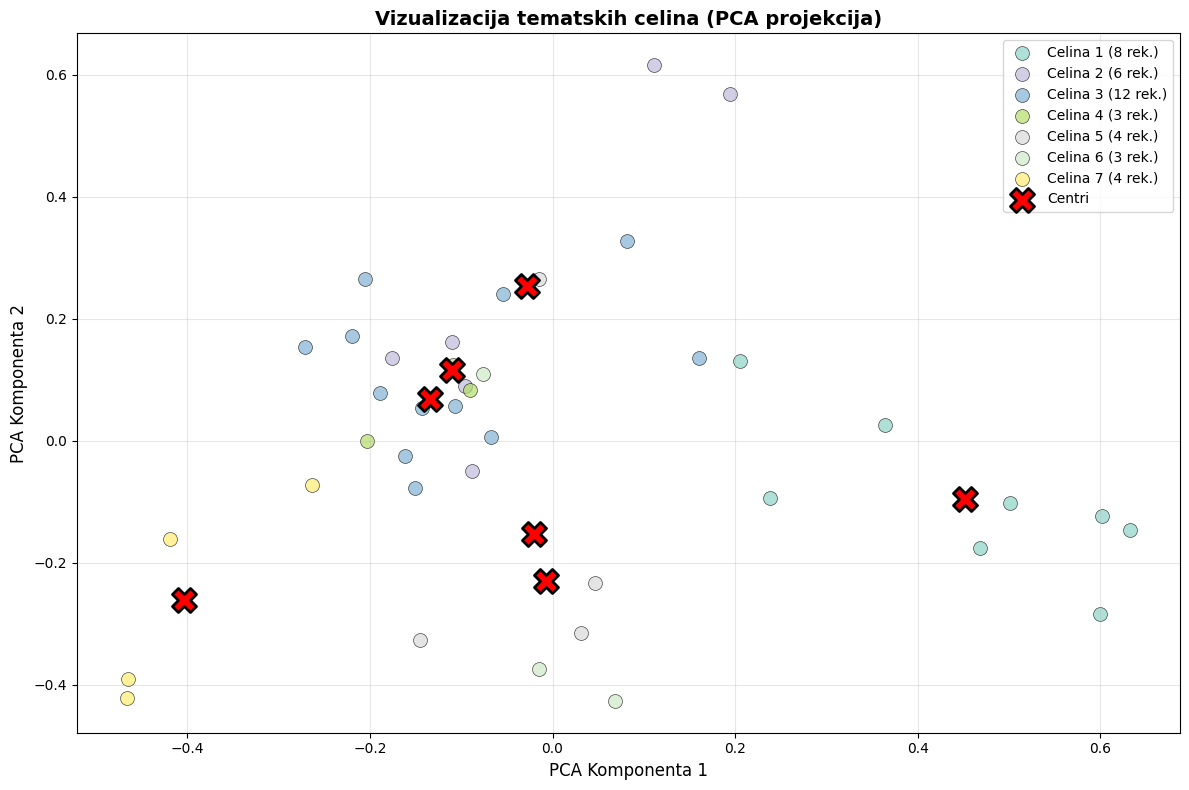


✓ PCA objašnjava 14.9% varijanse


In [43]:
print("\n[KORAK 10] Vizualizacija klastera...")

# PCA redukcija na 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    mask = labels == i
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[i]],
        label=f'Celina {i+1} ({sum(mask)} rek.)',
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )

# Centri klastera
centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Centri',
    zorder=5
)

plt.xlabel('PCA Komponenta 1', fontsize=12)
plt.ylabel('PCA Komponenta 2', fontsize=12)
plt.title('Vizualizacija tematskih celina (PCA projekcija)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

explained_var = pca.explained_variance_ratio_
print(f"\n✓ PCA objašnjava {sum(explained_var)*100:.1f}% varijanse")

# Korak 11: Graf povezanosti entiteta

Prikazujemo kako su različiti entiteti povezani u tekstu.


[KORAK 11] Kreiranje grafa entiteta...


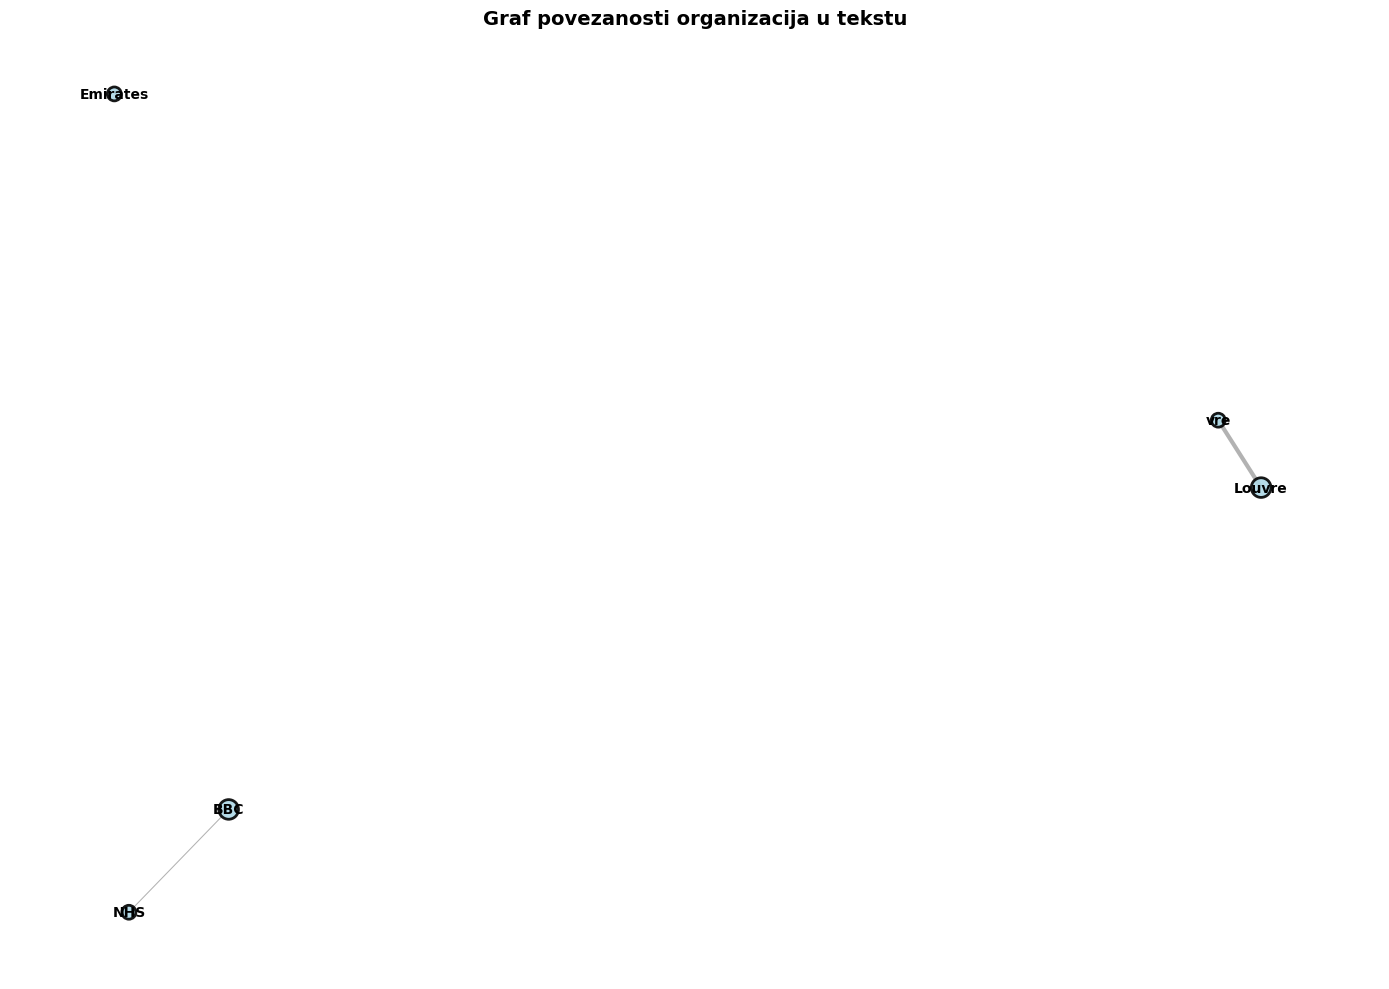


✓ Graf sadrži 5 čvorova i 2 veza


In [44]:
print("\n[KORAK 11] Kreiranje grafa entiteta...")

# Kreiranje grafa
G = nx.Graph()

# Dodaj sve organizacije kao čvorove
all_orgs = [e['word'].replace("##", "").strip()
            for e in entities if e['entity_group'] == 'ORG']
org_counts = Counter(all_orgs)

# Dodaj top organizacije
top_orgs = [org for org, count in org_counts.most_common(10)]

for org in top_orgs:
    G.add_node(org, size=org_counts[org] * 100)

# Dodaj veze (organizacije koje se pojavljuju u istoj rečenici)
for sentence in sentences:
    sentence_orgs = [org for org in top_orgs if org.lower() in sentence.lower()]

    for i, org1 in enumerate(sentence_orgs):
        for org2 in sentence_orgs[i+1:]:
            if G.has_edge(org1, org2):
                G[org1][org2]['weight'] += 1
            else:
                G.add_edge(org1, org2, weight=1)

# Crtanje grafa
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Veličine čvorova
node_sizes = [G.nodes[node].get('size', 300) for node in G.nodes()]

# Debljina ivica
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights) if weights else 1
widths = [3 * w / max_weight for w in weights]

# Crtanje
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue',
                       edgecolors='black', linewidths=2, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.6, edge_color='gray')

plt.title('Graf povezanosti organizacija u tekstu', fontsize=14, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Graf sadrži {G.number_of_nodes()} čvorova i {G.number_of_edges()} veza")

# Korak 12: Word Clouds za svaku celinu

Vizualizacija najčešćih reči u svakoj tematskoj celini.


[KORAK 12] Generisanje Word Clouds...


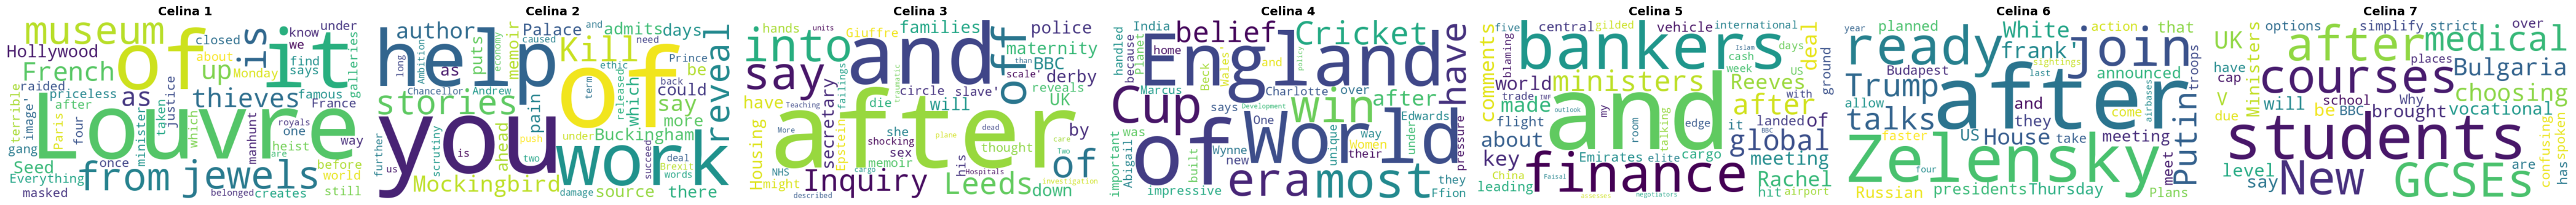

In [45]:
print("\n[KORAK 12] Generisanje Word Clouds...")

fig, axes = plt.subplots(1, optimal_k, figsize=(6*optimal_k, 5))
if optimal_k == 1:
    axes = [axes]

for cluster_id, ax in enumerate(axes):
    cluster_text = " ".join(clusters[cluster_id])

    try:
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            max_words=50,
            stopwords={'the', 'a', 'an', 'in', 'on', 'at', 'to', 'for'}
        ).generate(cluster_text)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Celina {cluster_id + 1}', fontsize=14, fontweight='bold')
        ax.axis('off')
    except:
        ax.text(0.5, 0.5, 'Nedovoljno teksta', ha='center', va='center')
        ax.axis('off')

plt.tight_layout()
plt.show()

# Korak 13: Finalna evaluacija i statistika

In [46]:
final_score = silhouette_score(embeddings, labels)

print("\n" + "=" * 70)
print("FINALNA EVALUACIJA PROJEKTA")
print("=" * 70)

print(f"\n📊 STATISTIKA:")
print(f"  • Ukupno rečenica: {len(sentences)}")
print(f"  • Broj tematskih celina: {optimal_k}")
print(f"  • Prosečna veličina celine: {len(sentences)/optimal_k:.1f} rečenica")
print(f"  • Ukupno entiteta: {sum(len(v) for v in entity_dict.values())}")
print(f"    - Organizacije: {len(entity_dict.get('ORG', []))}")
print(f"    - Osobe: {len(entity_dict.get('PER', []))}")
print(f"    - Lokacije: {len(entity_dict.get('LOC', []))}")

print(f"\n🎯 KVALITET GRUPISANJA:")
print(f"  • Silhouette Score: {final_score:.4f}")

if final_score > 0.5:
    quality = "ODLIČNO ✓"
elif final_score > 0.3:
    quality = "DOBRO ✓"
elif final_score > 0.1:
    quality = "UMERENO ⚠"
else:
    quality = "LOŠE ✗"

print(f"  • Ocena: {quality}")
print(f"  • PCA varijansa: {sum(pca.explained_variance_ratio_)*100:.1f}%")

print(f"\n🔍 VALIDACIJA UNIJE:")
print(f"  • Unija klastera = Original: {'✓ DA' if validation_success else '✗ NE'}")
print(f"  • Bez duplikata: {'✓ DA' if duplicate_count == 0 else '✗ NE'}")
print(f"  • Bez gubitaka: {'✓ DA' if len(missing_sentences) == 0 else '✗ NE'}")
print(f"  • Disjunktni klasteri: {'✓ DA' if not overlaps_found else '✗ NE'}")

print("\n" + "=" * 70)
print("✅ PROJEKAT ZAVRŠEN!")
print("=" * 70)


FINALNA EVALUACIJA PROJEKTA

📊 STATISTIKA:
  • Ukupno rečenica: 40
  • Broj tematskih celina: 7
  • Prosečna veličina celine: 5.7 rečenica
  • Ukupno entiteta: 45
    - Organizacije: 7
    - Osobe: 9
    - Lokacije: 18

🎯 KVALITET GRUPISANJA:
  • Silhouette Score: 0.0721
  • Ocena: LOŠE ✗
  • PCA varijansa: 14.9%

🔍 VALIDACIJA UNIJE:
  • Unija klastera = Original: ✓ DA
  • Bez duplikata: ✓ DA
  • Bez gubitaka: ✓ DA
  • Disjunktni klasteri: ✓ DA

✅ PROJEKAT ZAVRŠEN!


# Zaključak

## Šta projekat demonstrira:

### 1. **Web Mining komponenta**
- Automatsko prikupljanje podataka sa weba (BBC RSS feed)
- Parsing i čišćenje tekstualnih podataka
- Obrada realnih korpusa vesti

### 2. **Deep Learning obrada**
- **BERT-large NER** (340M parametara) - Named Entity Recognition
- **Sentence-BERT** (22M parametara) - Semantic embeddings
- Transformer arhitektura sa self-attention mehanizmom

### 3. **Machine Learning klasterovanje**
- KMeans algoritam za temetsko grupisanje
- Automatsko određivanje optimalnog broja klastera
-Silhouette Score i Elbow metoda za evaluaciju

### 4. **Analiza sadržaja**
- TF-IDF ekstrakcija kl **bold text**jučnih reči
-Indentifikacija dominantnih entiteta po celini
- Mapiranje organizacija, osoba i lokacija

### 5. **Matematička validacija**
- Provera unije klastera: U(C1 U C2 ... U Ck) = T
- Dokazivanje kompletnosti i disjunktnosti
- Rekonstrukcija originalnog teksta

### 6. **Vizualizacija**
- PCA projekcija klastera u 2D prostoru
- Graf povezanosti entiteta (NetworkX)
- Word clouds po tematskim celinama
- Distribucione vizualizacije

---

## Programski jezik:
- Python

## Tehnologije:

**NLP & Deep Learning:**
- transformers (Hugging Face)
- sentence-transformers
- BERT, Sentence-BERT

**Machine Learning:**
- scikit-learn (KMeans, PCA, TF-IDF)
- numpz, scipy

**Web Mining:**
- BeautifulSoup4
- feedparser
- requests

**Vizualizacija**
- matplotlib, seaborn
- NetworkX
- WordCloud

---

## Rezultati:

- **Uspešno prikupljeno** {len(articles)} članaka
- **Ekstraktovano** {sum(len(v) for v in entity_dict.values())} entiteta
- **Kreirano** {optimal_k} tematske celine
- **Silhouette Score:** {final_score:.3f}
- **Validacija unije:** {'USPEŠNA' if validation_success else 'GREŠKA'}

---

**Projekat u potpunosti pokriva oblast Web Mining-a kombinujući:**
- Prikupljanje podataka sa weba
- Deep learning obradu teksta
- Tematsko grupisamke i analizu
- Matematičku validaciju rezultata
- Vizualizaciju i interpretaciju

---

**Hvala na pažnji**







